## Catboost и Optuna с небольшим feature engineering для датасета "Titanic"

### Импорт библиотек

In [11]:
RANDOM_SEED= 42

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('dark_background')

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

`PassengerId`: Уникальный индекс/номер строки. Начинается с 1 (для первой строки) и увеличивается на 1 для каждой следующей. Рассматриваем его как идентификатор строки и, что логично, идентификатор пассажира (т.к. для каждого пассажира в датасете представлена только одна строка).  
`Survived`: Признак, показывающий был ли спасен данный пассажир или нет. 1 означает, что удалось выжить, и 0 - не удалось спастись.  
`Pclass`: Класс билета. 1 - означает Первый класс билета. 2 - означает Второй класс билета. 3 - означает Третий класс билета.   
`Name`: Имя пассажира. Имя также может содержать титулы и обращения. "Mr" для мужчин. "Mrs" для женщин. "Miss" для девушек (тут имеется в виду что для тех, кто не замужем, так было принято, да и сейчас тоже, говорить в западном обществе). "Master" для юношей.  
`Sex`: Пол пассажира. Либо мужчины (=Male) ,либо женщины (=Female).  
`Age`: Возраст пассажира. "NaN" значения в этой колонке означают, что возраст данного пассажира отсутствует/неизвестен/или не был записан в датасет.  
`SibSp`: Количество братьев/сестер или супругов, путешествующих с каждым пассажиром.
Parch: Количество родителей детей (Number of parents of children traveling with each passenger).  
`Ticket`: Номер билета.  
`Fare`: Сумма, которую заплатил пассажир за путешествие.  
`Cabin`: Номер каюты пассажира. "NaN" значения в этой колонке указывает на то, что номер каюты данного пассажира не был записан.  
`Embarked`: Порт отправления данного пассажира.

In [2]:
from catboost.datasets import titanic

df_train,df_test = titanic()
df_train.drop('PassengerId', axis=1, inplace=True)
df_test.drop('PassengerId', axis=1, inplace=True)
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### <a name="посмотрим-на-данные"></a>Посмотрим на данные

In [3]:
df_train.shape

(891, 11)

In [4]:
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
1 - (df_train.count() / len(df_train))

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

`Age` содержит около 20% недостающих значений, которые могут быть рассчитаны либо с помощью среднего значения, либо медианы.  
В `Cabin` пропущено около 77% значений.  
В `Embarted` пропущено около 0,22% значений.  

In [7]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
Cabin,204,147,B96 B98,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Восполнение пропущенных значений

In [28]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

data = df_train[['Survived', 'Pclass', 'Sex','Age', 'SibSp','Parch', 'Fare', 'Embarked']]

`OneHotEncoder` - для категориальных данных 

Перекодируем пол пассажира, очевидно, что это важно и в этом мы убедимся позже, с местом посадки это не так очевидно, но тем не менее

In [29]:
sx_em_dumm = pd.get_dummies(data[['Sex', 'Embarked']], drop_first=True)
data1 = pd.concat([data, sx_em_dumm], axis=1)
data1.drop(['Sex', 'Embarked'], axis=1, inplace=True)

Обработаем данные для того что бы их можно было использовать к KNN

In [30]:
scaler = MinMaxScaler()

datatrmd = scaler.fit_transform(data1)
df = pd.DataFrame(data=datatrmd, columns=data1.columns)

In [31]:
knn_imputer = KNNImputer(weights='distance', copy=True)
df1 = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)

Вернём данные к нормальному виду

In [32]:
datainv = scaler.inverse_transform(df1)
df2 = pd.DataFrame(data=datainv, columns=data1.columns)

In [33]:
train_data = pd.concat([df2, df_train[['Name']]], axis=1)
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Name
0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,1.0,"Braund, Mr. Owen Harris"
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,"Heikkinen, Miss. Laina"
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,1.0,"Allen, Mr. William Henry"


### Посмотрим на то как выживаемость коррелирует с признаками

1. Пол

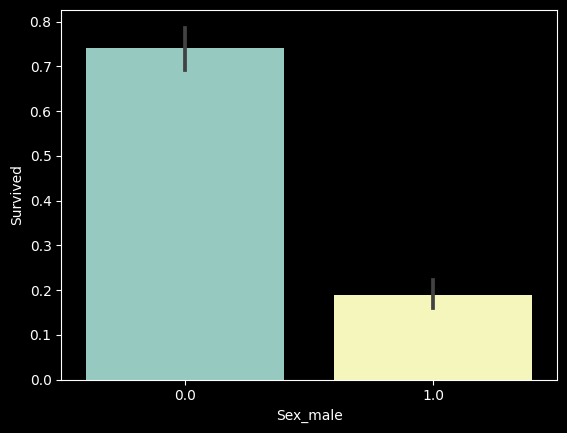

In [44]:
sns.barplot(data=train_data, x='Sex_male', y='Survived')
plt.show()

Выживаемость женщин выше

2. Pclass

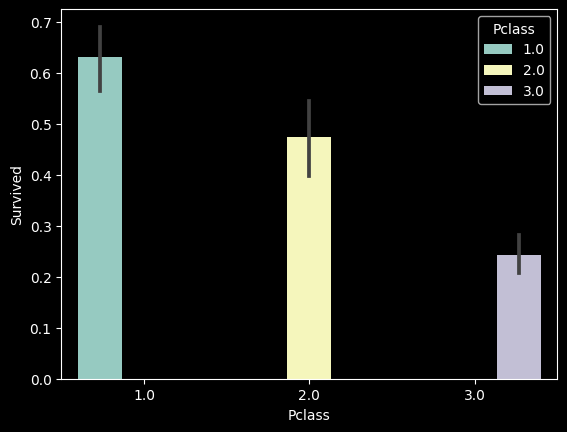

In [45]:
sns.barplot(data=train_data, x= 'Pclass', y='Survived', hue='Pclass')
plt.show()

Пассажиры 1-го и 2-го классов имеют более высокую вероятность выжить.

3. Возраст  
Мы создадим новую фичу - Age Group, которая поможет в классификации возраста и даст общую взаимосвязь с функцией выживания. Классификация будет следующей:

0-5 -> Младенец

6-15 -> Ребенок

16-35 -> Молодые

36-55 -> Взрослые

55-80 -> Старые

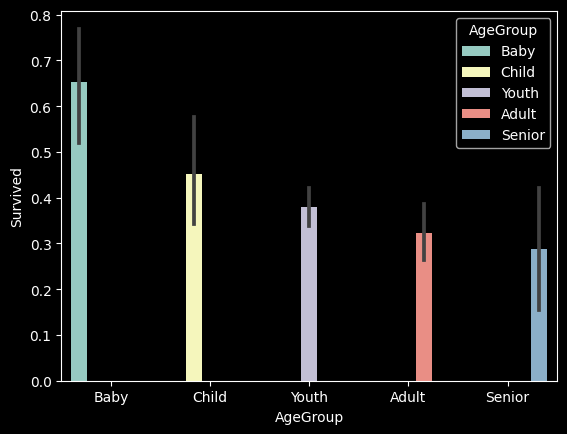

In [46]:
bins = [0, 6, 16, 36, 55, np.inf]
labels = ['Baby', 'Child', 'Youth', 'Adult', 'Senior']

train_data['AgeGroup'] = pd.cut(train_data['Age'], bins = bins, labels = labels)

sns.barplot(data=train_data, x='AgeGroup', y='Survived', hue='AgeGroup')
plt.show()

Моложе -> лучше физические способности -> лучше выживаемость. Детей спасали, потому что они - дети.

4. Количество родственников 

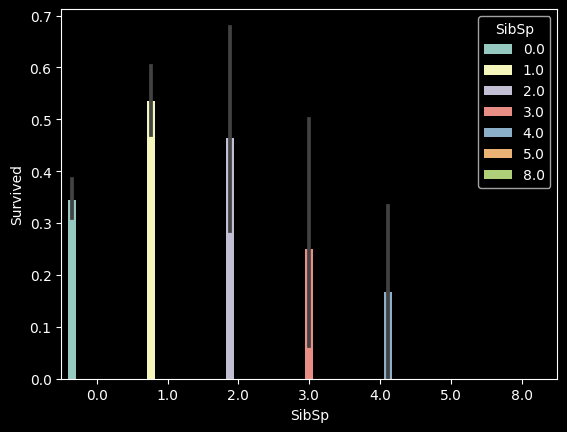

In [47]:
sns.barplot(data=train_data, x='SibSp', y='Survived', hue='SibSp')
plt.show()

5. Цена билета

In [48]:
train_data[['Fare', 'Pclass']][train_data['Fare'] == 0]

,Fare,Pclass
179,0.0,3.0
263,0.0,1.0
271,0.0,3.0
277,0.0,2.0
302,0.0,3.0
413,0.0,2.0
466,0.0,2.0
481,0.0,2.0
597,0.0,3.0
633,0.0,1.0


In [49]:
pclass_mean1 = round(train_data['Fare'][train_data['Pclass'] == 1].mean(), 4)
pclass_mean2 = round(train_data['Fare'][train_data['Pclass'] == 2].mean(), 4)
pclass_mean3 = round(train_data['Fare'][train_data['Pclass'] == 3].mean(), 4)
print(f'Mean 1: {pclass_mean1}, Mean 2: {pclass_mean2}, Mean : {pclass_mean3}')

Mean 1: 84.1547, Mean 2: 20.6622, Mean : 13.6756


In [50]:
train_data['Fare'][(train_data['Pclass'] == 1) & (train_data['Fare'] == 0)] = pclass_mean1
train_data['Fare'][(train_data['Pclass'] == 2) & (train_data['Fare'] == 0)] = pclass_mean2
train_data['Fare'][(train_data['Pclass'] == 3) & (train_data['Fare'] == 0)] = pclass_mean3

C:\Users\Asus\AppData\Local\Temp\ipykernel_21564\84957320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Fare'][(train_data['Pclass'] == 1) & (train_data['Fare'] == 0)] = pclass_mean1
C:\Users\Asus\AppData\Local\Temp\ipykernel_21564\84957320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Fare'][(train_data['Pclass'] == 2) & (train_data['Fare'] == 0)] = pclass_mean2
C:\Users\Asus\AppData\Local\Temp\ipykernel_21564\84957320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

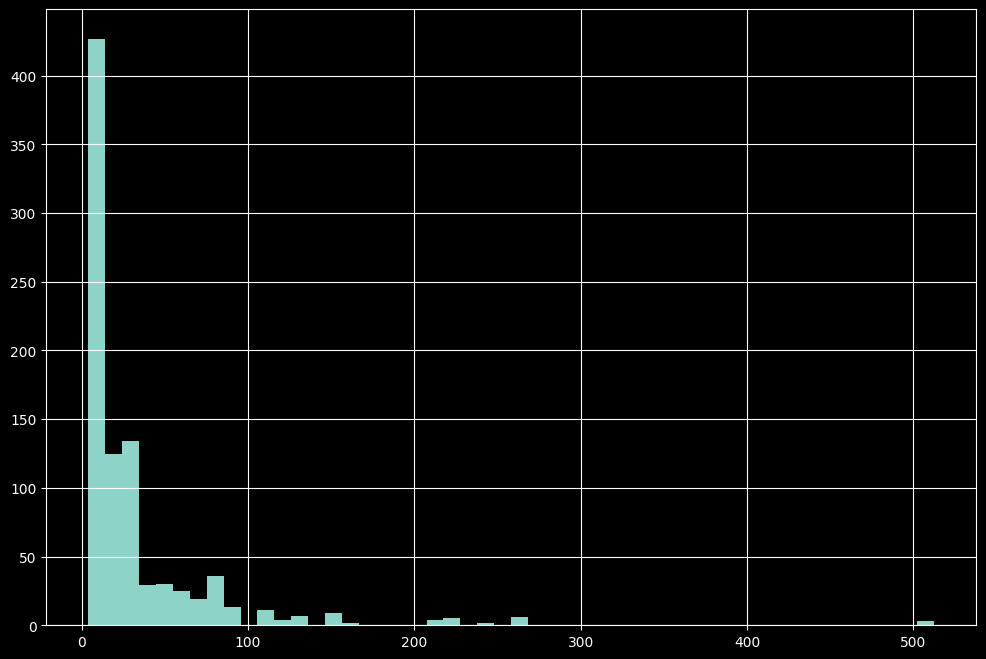

In [51]:
train_data['Fare'].hist(bins=50, figsize=(12, 8))
plt.show()

In [52]:
train_data['FareGroup'] = pd.cut(train_data['Fare'], bins = [0, 41, 101, 201, np.inf], labels=[1, 2, 3, 4]).astype(int)
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Name,AgeGroup,FareGroup
0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,1.0,"Braund, Mr. Owen Harris",Youth,1
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Adult,2
2,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,"Heikkinen, Miss. Laina",Youth,1
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Youth,2
4,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,1.0,"Allen, Mr. William Henry",Youth,1


7. Имя  
А именно титул, звание и тд

In [54]:
def titling(X, attrib):
    titles = []
    for i in range(len(X)):
        titles.append(str(df_train[attrib][i]).split('.')[0].split(',')[1].strip(' '))
    
    return titles

In [55]:
train_data['Title'] = titling(train_data, 'Name')
train_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

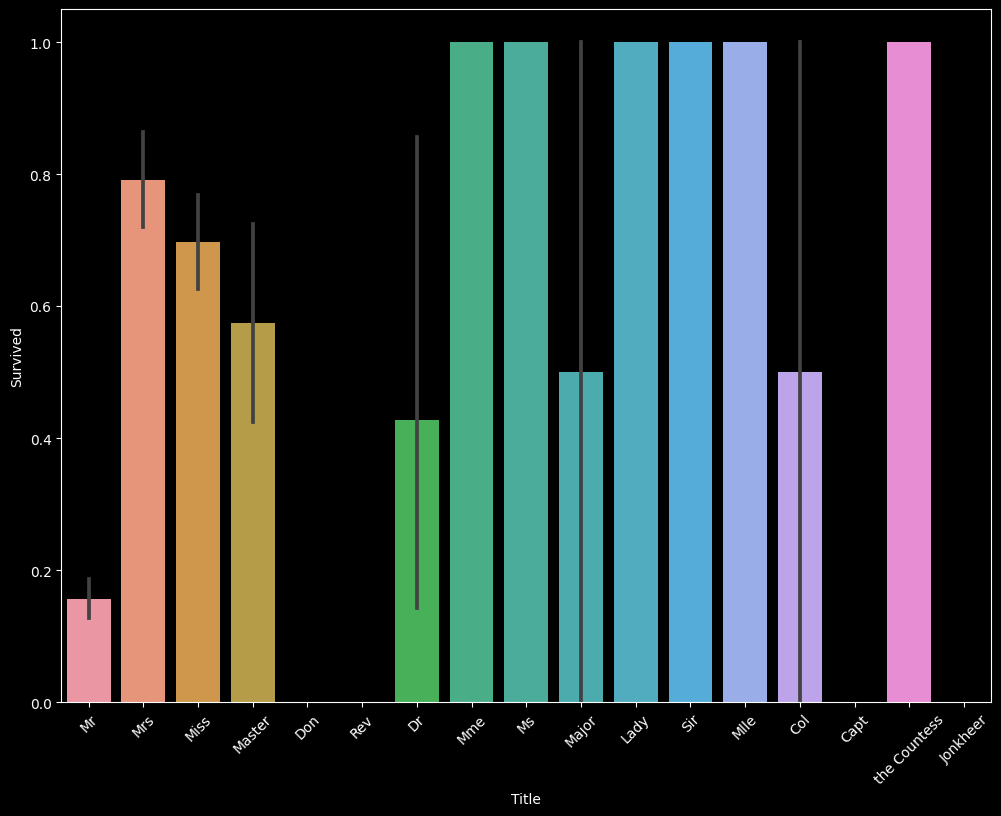

In [136]:
plt.figure(figsize=(12, 9))
g = sns.barplot(data=train_data, x='Title', y='Survived')
g.set_xticklabels(labels=train_data['Title'].unique(), rotation=45)
plt.show()

Разделим на три группы

In [58]:
def tilgrouping(X, attrib):
    royal = ['Master', 'Major', 'Lady', 'Sir', 'Col', 'the Countess']
    common = ['Mr', 'Mrs', 'Miss', 'Dr', 'Mme', 'Ms', 'Mlle']
    low = ['Don', 'Rev', 'Capt', 'Jonkheer']
    
    titleg = []
    
    for i in range(len(X[attrib])):
        if (X[attrib][i]) in royal:
            titleg.append(1)
        elif (X[attrib][i]) in common:
            titleg.append(2)
        elif (X[attrib][i]) in low:
            titleg.append(3)
    
    return titleg

In [63]:
train_data['TitleGroup'] = tilgrouping(train_data, 'Title')


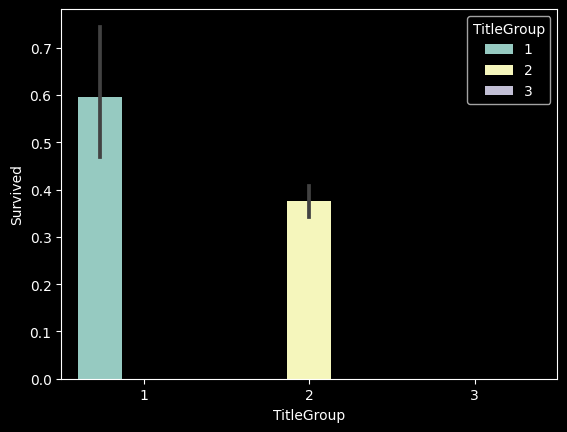

In [60]:
sns.barplot(data=train_data, x='TitleGroup', y='Survived', hue='TitleGroup')
plt.show()

Статные имеют выживаемость выше, т.к. их каюты находились на верхних палубах

8. Parch

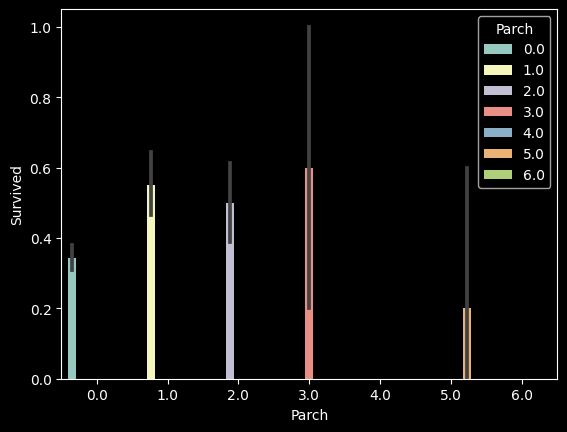

In [65]:
sns.barplot(data=train_data, x='Parch', y='Survived', hue='Parch')
plt.show()

Пассажиры, у которых были отношения между родителями и детьми, имели больше шансов выжить.

In [64]:
train_data.head(1)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Name,AgeGroup,FareGroup,Title,TitleGroup
0,0.0,3.0,22.0,1.0,0.0,7.25,1.0,0.0,1.0,"Braund, Mr. Owen Harris",Youth,1,Mr,2


### Обучение модели

Но сначала решим проблемы с категориальными переменными.

In [96]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore',
                    sparse_output=False,
                    ).set_output(transform='pandas')

ohe = enc.fit_transform(train_data[['AgeGroup', 'Title']])
ohe.columns

Index(['AgeGroup_Adult', 'AgeGroup_Baby', 'AgeGroup_Child', 'AgeGroup_Senior',
       'AgeGroup_Youth', 'Title_Capt', 'Title_Col', 'Title_Don', 'Title_Dr',
       'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Master',
       'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs',
       'Title_Ms', 'Title_Rev', 'Title_Sir', 'Title_the Countess'],
      dtype='object')

Но я использую CatBoost поэтому воспользуемся `cat_features`

In [125]:
X = train_data[['Pclass','Sex_male', 'Age', 'SibSp', 'Parch', 'Fare', 'AgeGroup', 'FareGroup', 'TitleGroup']]
y = train_data[['Survived']]

In [126]:
cat_features_indices = np.where(X.dtypes != float)[0]
cat_features_indices

array([6, 7, 8], dtype=int64)

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, 
                                                                 y, 
                                                                 test_size=0.3, 
                                                                 stratify=train_data[['Survived']],
                                                                 random_state=RANDOM_SEED)

In [128]:
from catboost import CatBoostClassifier, Pool

### Optuna для оптимизации подбора параметров

In [129]:
import optuna

Обучим по K-fold

In [123]:
scores = []
def optuna_optimize(trial):
  
    
    kf = KFold(n_splits=5, 
               shuffle=True, 
               random_state=RANDOM_SEED)

    for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        X_train1, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train1, y_val = y.iloc[train_index], y.iloc[val_index]

        train_pool = Pool(X_train1,
                        y_train1,
                        cat_features = cat_features_indices)
        test_pool = Pool(X_val,
                        y_val,
                        cat_features = cat_features_indices)
        
        model = CatBoostClassifier(
          learning_rate = trial.suggest_float("learning_rate", 0.001, 0.03, step=0.001),
          l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.25, 1.5, step=0.25),
          depth = trial.suggest_int('depth', 5, 9, step=1),
          early_stopping_rounds = 100,
          random_state = RANDOM_SEED,
          eval_metric='Accuracy',
          loss_function='Logloss'
        )

        model.fit(train_pool,
                eval_set = test_pool,
                verbose=0
                )

        scores.append(model.best_score_['validation']['Accuracy'])

    score = scores[-5:]
    
    score = np.mean(score)
    #print(scores) #list(scores_dict.values())
    #print(f'mean: {np.mean(scores)}, std :{np.std(scores)}')
    trial.report(score, i)    

    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return score
    

In [130]:
# создаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_logger = optuna.create_study(study_name='CatBoost optuna optimize',
                                   sampler = optuna.samplers.CmaEsSampler(),
                                   direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study_logger.optimize(optuna_optimize, n_trials=100, n_jobs=-1)

[I 2023-11-09 23:04:54,745] A new study created in memory with name: CatBoost optuna optimize
[I 2023-11-09 23:05:30,289] Trial 4 finished with value: 0.817741935483871 and parameters: {'learning_rate': 0.03, 'l2_leaf_reg': 1.0, 'depth': 6}. Best is trial 4 with value: 0.817741935483871.
[I 2023-11-09 23:05:35,623] Trial 5 finished with value: 0.8161290322580645 and parameters: {'learning_rate': 0.021, 'l2_leaf_reg': 1.5, 'depth': 5}. Best is trial 4 with value: 0.817741935483871.
[I 2023-11-09 23:05:35,697] Trial 0 finished with value: 0.8241935483870968 and parameters: {'learning_rate': 0.029, 'l2_leaf_reg': 0.25, 'depth': 6}. Best is trial 0 with value: 0.8241935483870968.
[I 2023-11-09 23:05:36,734] Trial 6 finished with value: 0.832258064516129 and parameters: {'learning_rate': 0.023, 'l2_leaf_reg': 0.75, 'depth': 7}. Best is trial 6 with value: 0.832258064516129.
[I 2023-11-09 23:05:37,201] Trial 3 finished with value: 0.8435483870967742 and parameters: {'learning_rate': 0.023, '

In [131]:
# выводим результаты на валидационной выборке
print("Наилучшие значения гиперпараметров {}".format(study_logger.best_params))
print("Accuracy на validation наборе: {:.4f}".format(study_logger.best_value))

Наилучшие значения гиперпараметров {'learning_rate': 0.017, 'l2_leaf_reg': 0.75, 'depth': 7}
Accuracy на validation наборе: 0.8581


In [132]:
pruned_trial = [t for t in study_logger.trials 
                if t.state == optuna.trial.TrialState.PRUNED]

print('num of pruned trials', len(pruned_trial))

num of pruned trials 74


### Вывод  
Полученный `score = 0.8581` выше среднего скора, наблюдаемого в ноутбуках на просторе интернета. Проведенный feature engineering можно считать успешным, optuna также внесла свой вклад в обучение и помогла подобрать хорошие гиперпараметры.